<a href="https://colab.research.google.com/github/SEOYUNJE/Endoscope-Object-Detection/blob/main/EfficientDet/ColonoScopy/Train/baseline_v1_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install -q opendatasets

import opendatasets as od
od.download('https://www.kaggle.com/datasets/seoyunje/colonoscopy-256x256-resized-png')
od.download('https://www.kaggle.com/datasets/msyu78/metadataset')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: msyu78
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/seoyunje/colonoscopy-256x256-resized-png


100%|██████████| 190M/190M [00:02<00:00, 73.4MB/s]



Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: msyu78
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/msyu78/metadataset


100%|██████████| 657k/657k [00:00<00:00, 144MB/s]

## 1. Import Library
___

### Install EfficientDet Library

In [4]:
!pip install -q git+https://github.com/rwightman/efficientdet-pytorch

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 66.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [5]:
!pip install -q colorama

In [6]:
import os
import sys
import pickle
import random
import gc
import ctypes
import copy
from collections import defaultdict

from glob import glob
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from colorama import Fore
from PIL import Image
import cv2

import torch; import timm
print(f'{Fore.BLUE} => Pytorch Version: ', torch.__version__)
print(f'{Fore.BLUE} => Timm Version: ', timm.__version__)
import torch.nn as nn
from torch.cuda import amp
import torch.functional as F
from torch.utils.data import DataLoader, Dataset

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

## EfficientDet Library
from effdet.efficientdet import EfficientDet, HeadNet, BiFpn
from effdet.bench import DetBenchTrain, DetBenchPredict
# default config: tf_efficientdet_d1
from effdet.config import get_efficientdet_config, default_detection_model_configs
from effdet.config import default_detection_train_config, get_fpn_config

from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
import warnings
warnings.filterwarnings('ignore')

print(f'{Fore.BLUE} => Installed Necessary Library')

 => Pytorch Version:  2.5.1+cu124
 => Timm Version:  1.0.15


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


 => Installed Necessary Library


### Configuration

In [7]:
class CFG:
    output_dir = '/content/drive/MyDrive/Endoscope Detection/colonoscopy/EfficientDet/experiment3'
    seed = 2025

    img_size = [256, 256]
    imgdir = '/content/colonoscopy-256x256-resized-png'
    model_name = 'resdet50'
    num_classes = 3 # Ulcer, Polyp, Cancer

    num_epochs = 50
    train_bs = 4 # 8->4
    valid_bs = train_bs * 2
    scheduler_type = 'CosineAnnealingWarmRestarts' # ReduceLROnPlateau, CosineAnnealingWarmRestarts
    base_lr = 1e-3
    min_lr = 1e-9
    weight_decay = 1e-4
    T_mult = 1

    n_accumulate = 1 ## Gradient Accumulation
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    device_count = torch.cuda.device_count()

print('Device is', CFG.device)
print('Num GPU of machine is', CFG.device_count)

Device is cuda
Num GPU of machine is 1


### Reproducibility

In [8]:
def seed_everything(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    os.environ['PYTHONHASHSEED'] = str(seed)

seed_everything(CFG.seed)

### Clean_memory

In [9]:
def clean_memory():
    ctypes.CDLL('libc.so.6').malloc_trim(0)
    gc.collect()

clean_memory()

## 2. Utils
___

**draw_bbox**

In [10]:
def draw_bbox(image, box, label_name, label_id, color):
    alpha_text = 0.8 # text box color
    thickness = 2
    overlay_bbox = image.copy()
    overlay_text = image.copy()
    output = image.copy()

    text_width, text_height = cv2.getTextSize(str(label_id) + ' ' + label_name.upper(), cv2.FONT_HERSHEY_SIMPLEX, 0.4, 1)[0]
    # Adding Text Box
    cv2.rectangle(overlay_text, (box[0],box[1]-text_height-5),
                  (box[0]+text_width, box[1]), color, -1)
    cv2.addWeighted(overlay_text, alpha_text, output, 1-alpha_text, 0, output)
    cv2.rectangle(output, (box[0], box[1]), (box[2],box[3]), color, thickness)
    cv2.putText(output, str(label_id) + ' ' + label_name.upper(), (box[0], box[1]-3),
               cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)

    return output

**AverageMeter**

In [11]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

**Collate_fn**

In [12]:
def collate_fn(batch):
    return tuple(zip(*batch))

## 3. Build Dataset
___

In [13]:
df = pd.read_csv('/content/metadataset/colonoscopy_data2.csv')
print('Shape of DataFrame: ', df.shape)
print(display(df))

Shape of DataFrame:  (2496, 14)


,image_id,height,width,organ,lesion_label,location,shape_type_polygon,polygon_mask,bounding_box_shape,x_min,y_min,x_max,y_max,lesion
0,2_1_00001.png,2048,2048,colonoscopy,0,1,polygon,"1484.52,775.16;1516.82,710.56;1519.30,640.99;1...",rectangle,838.559006,149.068323,1519.304348,807.453416,ulcer
1,2_1_00001.png,2048,2048,colonoscopy,0,1,polygon,"1663.40,1478.26;1653.47,1426.09;1616.20,1388.8...",rectangle,1310.608696,1324.223602,1663.403727,1868.322981,ulcer
2,2_1_00002.png,2048,2048,colonoscopy,0,1,polygon,"687.01,223.60;687.01,273.29;704.40,337.89;726....",rectangle,687.006211,168.944099,1591.354037,1465.838509,ulcer
3,2_1_00002.png,2048,2048,colonoscopy,0,1,polygon,"826.14,1200.00;878.31,1207.45;932.97,1187.58;9...",rectangle,488.248447,434.782609,1007.503106,1207.453416,ulcer
4,2_1_00002.png,2048,2048,colonoscopy,0,1,polygon,"575.20,1038.51;520.55,1050.93;468.37,1050.93;4...",rectangle,212.472050,725.465839,607.503106,1050.931677,ulcer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2491,2_2_05111.png,2048,2048,colonoscopy,1,1,polygon,"1113.11,963.83;1070.55,976.60;1032.26,995.74;1...",rectangle,898.212766,948.936170,1493.957447,1527.659574,polyp
2492,2_2_05112.png,2048,2048,colonoscopy,1,1,polygon,"1230.13,1397.87;1187.57,1408.51;1138.64,1425.5...",rectangle,866.297872,1370.212766,1821.617021,1889.361702,polyp
2493,2_2_05113.png,2048,2048,colonoscopy,1,1,polygon,"1021.62,642.55;979.06,653.19;938.64,668.09;898...",rectangle,810.978723,642.553192,1268.425532,1038.297872,polyp
2494,2_2_05114.png,2048,2048,colonoscopy,1,1,polygon,"883.32,972.34;845.02,997.87;806.72,1025.53;776...",rectangle,772.680851,970.212766,1121.617021,1223.404255,polyp


None


In [14]:
## 궤양(Ulcer): 1
## 용종(Polyp): 2
## 암(Cancer): 3


df['lesion_label'] = df['lesion_label'] + 1

In [15]:
train_id = [x.split('/')[-1] for x in glob('/content/colonoscopy-256x256-resized-png/train/*.png')]
test_id = [x.split('/')[-1] for x in glob('/content/colonoscopy-256x256-resized-png/test/*.png')]

train_df = df[df['image_id'].isin(train_id)].reset_index(drop=True)
test_df = df[df['image_id'].isin(test_id)].reset_index(drop=True)

print('=> Number of Unique Image_id in Train: ', train_df.image_id.nunique())
print('=> Number of Unique Image_id in Test: ', test_df.image_id.nunique())

=> Number of Unique Image_id in Train:  1596
=> Number of Unique Image_id in Test:  400


In [16]:
gkf = GroupKFold(n_splits=5)

for i, (_, val_idx) in enumerate(gkf.split(train_df, groups=train_df['image_id'])):
    train_df.loc[val_idx, 'fold'] = i

valid_df = train_df[train_df['fold'] == 0].reset_index(drop=True)
train_df = train_df[train_df['fold'] != 0].reset_index(drop=True)

print('Images in train_df: ', train_df['image_id'].nunique())
print('Images in valid_df: ', valid_df['image_id'].nunique())

Images in train_df:  1277
Images in valid_df:  319


In [17]:
def get_train_transform():
    return A.Compose(
        [A.HorizontalFlip(p=0.4),
         A.Resize(*CFG.img_size, p=1.0),
         A.RandomBrightnessContrast(p=0.3),
         A.CLAHE(p=0.3),
         A.RandomRotate90(p=0.3)
         ],
         bbox_params = A.BboxParams(format='pascal_voc', label_fields=['labels'])
    )

def get_valid_transform():
    return A.Compose(
        [A.Resize(*CFG.img_size, p=1.0),
         ],
        bbox_params = A.BboxParams(format='pascal_voc', label_fields=['labels'])
    )

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.0 MB/s eta 0:00:00


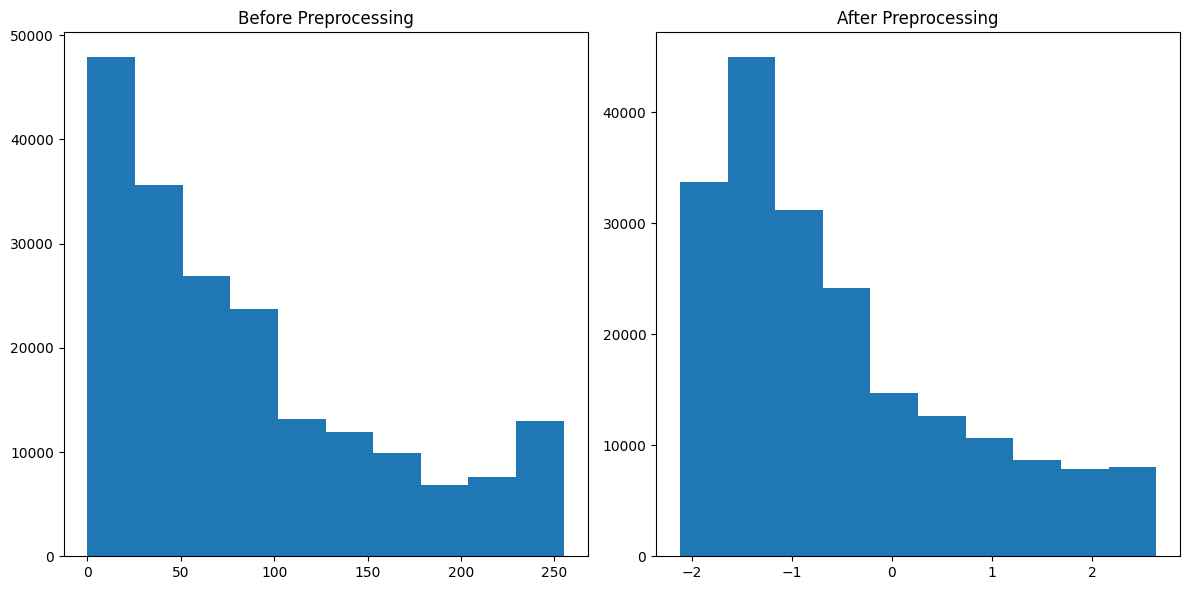

In [18]:
!pip install -q efficientnet

from efficientnet.keras import preprocess_input

path = '/content/colonoscopy-256x256-resized-png/train/2_1_00001.png'
img = Image.open(path)
img = np.array(img)
img_preprocessed = preprocess_input(img)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title('Before Preprocessing')
plt.hist(img.flatten())

plt.subplot(1,2,2)
plt.title('After Preprocessing')
plt.hist(img_preprocessed.flatten())

plt.tight_layout()
plt.show()

In [19]:
### Bbox Format: Ymin, Xmin, Ymax, Xmax
### Image Preprocessing: Normalization

class ColonoscopyDataset(Dataset):
    def __init__(self, df, image_dir=None, mode='train', transforms=None):
        super(ColonoscopyDataset).__init__()

        self.image_ids = df['image_id'].unique()
        self.df = df
        self.mode = mode
        self.image_dir = image_dir
        self.transforms = transforms

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, index):
        image_id = self.image_ids[index]

        image, boxes, labels = self.load_image_and_boxes(image_id)

        target= {}
        target['boxes'] = torch.tensor(boxes).to(torch.float32)
        target['labels'] = torch.tensor(labels).to(torch.int64)
        target['image_id'] = torch.tensor([index])

        if self.transforms:
            sample = self.transforms(image=image, bboxes=boxes, labels=labels)

            if len(sample['bboxes']) > 0:
                image = sample['image']
                image = preprocess_input(image)
                image = torch.tensor(image.transpose(2,0,1).astype(np.float32))
                target['boxes'] = torch.tensor(sample['bboxes']).to(torch.float32)
                target['labels'] = torch.tensor(sample['labels']).to(torch.int64)
                # Xmin, Ymin, Xmax, Ymax => Ymin, Xmin, Ymax, Xmax
                target['boxes'][:,[0,1,2,3]] = target['boxes'][:,[1,0,3,2]]
            else:
                image = preprocess_input(image)
                image = torch.tensor(image.transpose(2,0,1).astype(np.float32))
                target['boxes'][:,[0,1,2,3]] = target['boxes'][:,[1,0,3,2]]

        if self.mode == 'train':
            return image, target, image_id
        else:
            return image, image_id

    def load_image_and_boxes(self, image_id):
        path = os.path.join(f'{self.image_dir}', 'train', image_id)
        image = Image.open(path)
        image = np.array(image)
        resized_height, resized_width = image.shape[:2]

        ## FillNan
        m = np.nanmean(image)
        image = np.nan_to_num(image, nan=m)

        records = self.df[self.df['image_id'] == image_id]
        boxes = records[['x_min','y_min','x_max','y_max']].values
        boxes[:,[0,2]] *= resized_width / records['width'].values[0]
        boxes[:,[1,3]] *= resized_height / records['height'].values[0]

        labels = records['lesion_label'].values

        return image, boxes, labels

In [20]:
train_dataset = ColonoscopyDataset(
         df = train_df,
         image_dir = CFG.imgdir,
         transforms = get_train_transform()
)

valid_dataset = ColonoscopyDataset(
         df = valid_df,
         image_dir = CFG.imgdir,
         transforms = get_valid_transform()
)

## 3. Visualization Gastroscopy Augmentation
___

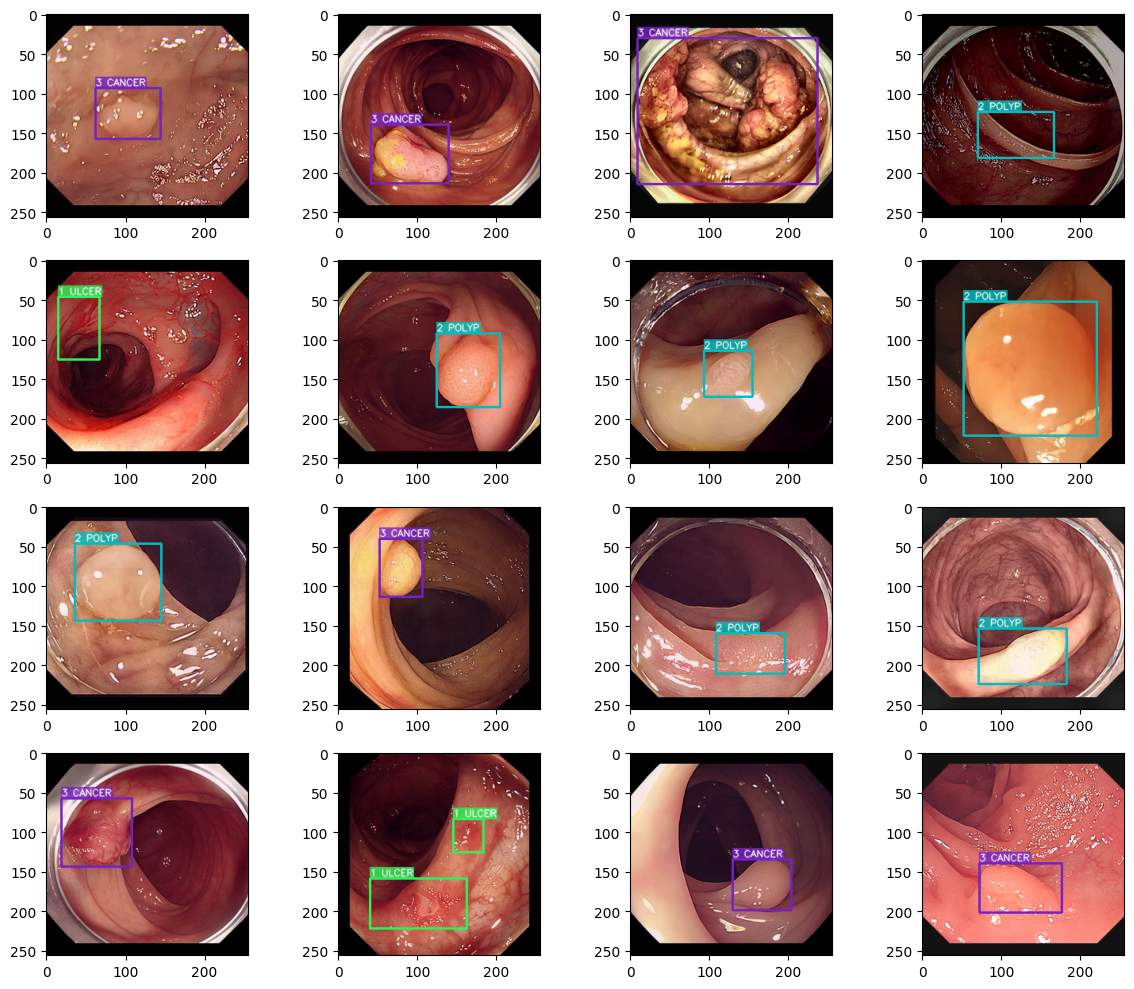

In [21]:
classes = {1: 'Ulcer', 2: 'Polyp', 3: 'Cancer'}

label2color = [[random.randint(0,255) for i in range(3)] for _ in range(CFG.num_classes)]

plt.style.use('default')
plt.figure(figsize=(12,10))

for i in range(16):
    j = np.random.randint(0, len(train_dataset), 1)[0]
    image, target, image_id = train_dataset[j]
    img = image.permute(1,2,0).cpu().numpy()
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = img*std + mean

    img = (img*255).astype('uint8')
    boxes = target['boxes'].cpu().numpy()
    boxes[:,[0,1,2,3]] = boxes[:,[1,0,3,2]]
    labels = target['labels'].cpu().numpy()

    plt.subplot(4,4,i+1)
    for label_id, box in zip(labels, boxes):
        color = label2color[label_id - 1]
        img = draw_bbox(img, list(np.int_(box)), classes[label_id], label_id, color)
        plt.imshow(img)
        #plt.axis('off')
    clean_memory()
    del image, target, image_id

plt.tight_layout()
plt.show()

## 4. Build Trainer Engine
___

**Scheduler**

In [22]:
def fetch_scheduler(scheduler_type, optimizer, loader):
    if scheduler_type == 'ReduceLROnPlateau':
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', verbose=False, factor=0.1, patience=5, threshold=1e-3,
            threshold_mode='abs', min_lr = CFG.min_lr
        )
        return scheduler

    elif scheduler_type == 'CosineAnnealingLR':
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=CFG.num_epochs*len(loader), eta_min=CFG.min_lr,
            last_epoch=-1, verbose=False
        )
        return scheduler

    elif scheduler_type == 'CosineAnnealingWarmRestarts':
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
            optimizer, T_0 = CFG.num_epochs*len(loader)//3, T_mult=CFG.T_mult, eta_min=CFG.min_lr,
            last_epoch=-1, verbose=False
        )
        return scheduler

    else:
        return None

**Build_model**

In [23]:
def build_model():
    config = get_efficientdet_config(model_name=CFG.model_name)
    config.num_classes = CFG.num_classes
    config.image_size = CFG.img_size
    config.max_det_per_image = 100

    net = EfficientDet(config, pretrained_backbone=True)
    net.box_net = HeadNet(config, num_outputs=4)
    net.class_net= HeadNet(config, num_outputs=config.num_classes)

    return DetBenchTrain(net, create_labeler=True)

In [24]:
class Trainer:
    def __init__(self, model, optimizer, scheduler, device, num_epochs, output_dir):
        self.model = model
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.device = device
        self.num_epochs = num_epochs

        self.history = defaultdict(list)
        self.summary_loss = AverageMeter(); self.box_loss = AverageMeter(); self.class_loss = AverageMeter()
        self.val_summary_loss = AverageMeter(); self.val_box_loss = AverageMeter(); self.val_class_loss = AverageMeter()

        self.best_loss = 10**5
        self.best_epoch = 0

        self.output_dir = output_dir

        if not os.path.exists(self.output_dir):
            os.makedirs(self.output_dir, exist_ok=True)

        print(f'{Fore.BLUE} ### Trainer Prepared, Device is {self.device}')

    def fit(self, train_loader, valid_loader):

        for epoch in range(1, self.num_epochs + 1):
            print(f'{Fore.BLUE}#'*25)
            print(f'{Fore.BLUE}### Epoch {epoch}/{self.num_epochs}')
            print(f'{Fore.BLUE}#'*25)

            train_loss = self.train_one_epoch(train_loader)
            valid_loss = self.valid_one_epoch(valid_loader)

            print(f'{Fore.BLUE}Train Loss: {train_loss:.4f} | Valid Loss: {valid_loss:.4f}')

            self.model.eval()
            last_model_wts = copy.deepcopy(self.model.model.state_dict())
            torch.save(last_model_wts, f'{self.output_dir}/last-checkpoint.bin')

            if valid_loss <= self.best_loss:
                self.best_loss = valid_loss
                self.best_epoch = epoch
                best_model_wts = copy.deepcopy(self.model.model.state_dict())

                torch.save(best_model_wts, f'{self.output_dir}/best-checkpoint.bin')

            self.model.model.load_state_dict(torch.load(f'{self.output_dir}/best-checkpoint.bin'))

        return self.model, self.history


    def train_one_epoch(self, train_loader):
        self.model.train()

        pbar = tqdm(enumerate(train_loader), total=len(train_loader), desc='Training')

        for step, (images, targets, image_ids) in pbar:
            images = torch.stack(images) ## Adding Batch Dimensional
            images = images.to(self.device).float()
            batch_size = images.size(0)

            target_res = {}
            boxes = [target['boxes'].to(self.device).float() for target in targets]
            labels = [target['labels'].to(self.device).float() for target in targets]

            target_res['bbox'] = boxes
            target_res['cls'] = labels

            output = self.model(images, target_res)

            loss = output['loss']; self.summary_loss.update(loss.detach().item(), batch_size)
            cls_loss = output['class_loss']; self.class_loss.update(cls_loss.detach().item(), batch_size)
            bx_loss = output['box_loss']; self.box_loss.update(bx_loss.detach().item(), batch_size)


            (loss / CFG.n_accumulate).backward()

            if (step + 1) % CFG.n_accumulate == 0:

               self.optimizer.step()

               self.optimizer.zero_grad()

               if CFG.scheduler_type == 'ReduceLROnPlateau':
                   self.scheduler.step(metrics=self.summary_loss.avg)
               else:
                   self.scheduler.step()

            mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0

            self.history['total_loss'].append(self.summary_loss.avg)
            self.history['box_loss'].append(self.box_loss.avg)
            self.history['class_loss'].append(self.class_loss.avg)
            self.history['LR'].append(self.optimizer.param_groups[0]["lr"])

            pbar.set_postfix(
                  total_loss = f'{self.summary_loss.avg:.5f}',
                  cls_loss = f'{self.class_loss.avg:.5f}',
                  box_loss = f'{self.box_loss.avg:.5f}',
                  lr = f'{self.optimizer.param_groups[0]["lr"]:.9f}',
                  gpu_mem = f'{mem} GB'
             )

        torch.cuda.empty_cache()
        clean_memory()

        return self.summary_loss.avg

    @torch.no_grad()
    def valid_one_epoch(self, valid_loader):
        self.model.eval()

        pbar = tqdm(enumerate(valid_loader), total=len(valid_loader), desc='Validation')
        for step, (images, targets, image_ids) in pbar:
            with torch.no_grad():
                images = torch.stack(images)
                batch_size = images.size(0)

                images = images.to(self.device).float()
                boxes = [target['boxes'].to(self.device).float() for target in targets]
                labels = [target['labels'].to(self.device).float() for target in targets]

                target_res = {}
                target_res['bbox'] = boxes
                target_res['cls'] = labels
                target_res['img_scale'] = torch.tensor([1.0]*batch_size,
                                                       dtype=torch.float).to(self.device)
                target_res['img_size'] = torch.tensor([images[0].shape[-2:]]*batch_size,
                                                       dtype=torch.float).to(self.device)
                output = self.model(images, target_res)
                loss = output['loss']; self.val_summary_loss.update(loss.detach().item(), batch_size)
                cls_loss = output['class_loss']; self.val_class_loss.update(cls_loss.detach().item(), batch_size)
                bx_loss = output['box_loss']; self.val_box_loss.update(bx_loss.detach().item(), batch_size)

                mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0

                self.history['valid_total_loss'].append(self.val_summary_loss.avg)
                self.history['valid_box_loss'].append(self.val_box_loss.avg)
                self.history['valid_class_loss'].append(self.val_class_loss.avg)

                pbar.set_postfix(
                     valid_total_loss = f'{self.val_summary_loss.avg:.5f}',
                     valid_cls_loss = f'{self.val_class_loss.avg:.5f}',
                     valid_box_loss = f'{self.val_box_loss.avg:.5f}',
                     lr = f'{self.optimizer.param_groups[0]["lr"]:.9f}',
                     gpu_mem = f'{mem} GB'
                )

        torch.cuda.empty_cache()
        clean_memory()

        return self.val_summary_loss.avg

In [25]:
def run_training(train_loader, valid_loader):

    model = build_model()
    model.to(CFG.device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=CFG.base_lr, weight_decay=CFG.weight_decay)
    scheduler = fetch_scheduler(CFG.scheduler_type, optimizer, train_loader)

    trainer = Trainer(model=model, optimizer=optimizer, scheduler=scheduler,
            device=CFG.device, num_epochs=CFG.num_epochs, output_dir=CFG.output_dir)

    best_model, history = trainer.fit(train_loader, valid_loader)

    del train_loader, valid_loader
    clean_memory()

    return best_model, history


In [26]:
train_loader = DataLoader(
        train_dataset,
        batch_size = CFG.train_bs,
        shuffle = True,
        drop_last = False,
        pin_memory = True,
        collate_fn = collate_fn,
    )

valid_loader = DataLoader(
        valid_dataset,
        batch_size = CFG.valid_bs,
        shuffle = False,
        drop_last = False,
        pin_memory = True,
        collate_fn = collate_fn
    )

In [27]:
best_model, history = run_training(train_loader, valid_loader)

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

 ### Trainer Prepared, Device is cuda
#########################
### Epoch 1/50
#########################


Validation: 100%|██████████| 40/40 [00:06<00:00,  6.64it/s, gpu_mem=0.578813952 GB, lr=0.000991143, valid_box_loss=0.00953, valid_cls_loss=0.74850, valid_total_loss=1.22520]


Train Loss: 3.8114 | Valid Loss: 1.2252
#########################
### Epoch 2/50
#########################


Validation: 100%|██████████| 40/40 [00:04<00:00,  8.29it/s, gpu_mem=0.769654784 GB, lr=0.000964884, valid_box_loss=0.00951, valid_cls_loss=0.69072, valid_total_loss=1.16614]


Train Loss: 2.4393 | Valid Loss: 1.1661
#########################
### Epoch 3/50
#########################


Validation: 100%|██████████| 40/40 [00:04<00:00,  8.12it/s, gpu_mem=0.803209216 GB, lr=0.000922155, valid_box_loss=0.00895, valid_cls_loss=0.65449, valid_total_loss=1.10213]


Train Loss: 1.9430 | Valid Loss: 1.1021
#########################
### Epoch 4/50
#########################


Validation: 100%|██████████| 40/40 [00:05<00:00,  7.92it/s, gpu_mem=0.843055104 GB, lr=0.000864468, valid_box_loss=0.00861, valid_cls_loss=0.63047, valid_total_loss=1.06111]


Train Loss: 1.6739 | Valid Loss: 1.0611
#########################
### Epoch 5/50
#########################


Validation: 100%|██████████| 40/40 [00:05<00:00,  7.91it/s, gpu_mem=0.826277888 GB, lr=0.000793869, valid_box_loss=0.00796, valid_cls_loss=0.60263, valid_total_loss=1.00066]


Train Loss: 1.5010 | Valid Loss: 1.0007
#########################
### Epoch 6/50
#########################


Validation: 100%|██████████| 40/40 [00:04<00:00,  8.10it/s, gpu_mem=0.830472192 GB, lr=0.000712858, valid_box_loss=0.00750, valid_cls_loss=0.58056, valid_total_loss=0.95561]


Train Loss: 1.3766 | Valid Loss: 0.9556
#########################
### Epoch 7/50
#########################


Validation: 100%|██████████| 40/40 [00:04<00:00,  8.13it/s, gpu_mem=0.840957952 GB, lr=0.000624305, valid_box_loss=0.00721, valid_cls_loss=0.56603, valid_total_loss=0.92629]


Train Loss: 1.2817 | Valid Loss: 0.9263
#########################
### Epoch 8/50
#########################


Validation: 100%|██████████| 40/40 [00:05<00:00,  7.71it/s, gpu_mem=0.830472192 GB, lr=0.000531349, valid_box_loss=0.00693, valid_cls_loss=0.55030, valid_total_loss=0.89657]


Train Loss: 1.2063 | Valid Loss: 0.8966
#########################
### Epoch 9/50
#########################


Validation: 100%|██████████| 40/40 [00:05<00:00,  7.41it/s, gpu_mem=0.840957952 GB, lr=0.000437281, valid_box_loss=0.00666, valid_cls_loss=0.53548, valid_total_loss=0.86864]


Train Loss: 1.1450 | Valid Loss: 0.8686
#########################
### Epoch 10/50
#########################


Validation: 100%|██████████| 40/40 [00:05<00:00,  7.52it/s, gpu_mem=0.843055104 GB, lr=0.000345436, valid_box_loss=0.00644, valid_cls_loss=0.52187, valid_total_loss=0.84388]


Train Loss: 1.0922 | Valid Loss: 0.8439
#########################
### Epoch 11/50
#########################


Validation: 100%|██████████| 40/40 [00:05<00:00,  7.55it/s, gpu_mem=0.834666496 GB, lr=0.000259067, valid_box_loss=0.00624, valid_cls_loss=0.50882, valid_total_loss=0.82103]


Train Loss: 1.0459 | Valid Loss: 0.8210
#########################
### Epoch 12/50
#########################


Validation: 100%|██████████| 40/40 [00:05<00:00,  7.19it/s, gpu_mem=0.8388608 GB, lr=0.000181234, valid_box_loss=0.00608, valid_cls_loss=0.49742, valid_total_loss=0.80122]


Train Loss: 1.0051 | Valid Loss: 0.8012
#########################
### Epoch 13/50
#########################


Validation: 100%|██████████| 40/40 [00:05<00:00,  7.23it/s, gpu_mem=0.840957952 GB, lr=0.000114695, valid_box_loss=0.00592, valid_cls_loss=0.48729, valid_total_loss=0.78332]


Train Loss: 0.9684 | Valid Loss: 0.7833
#########################
### Epoch 14/50
#########################


Validation: 100%|██████████| 40/40 [00:05<00:00,  7.23it/s, gpu_mem=0.8388608 GB, lr=0.000061808, valid_box_loss=0.00579, valid_cls_loss=0.47819, valid_total_loss=0.76757]


Train Loss: 0.9345 | Valid Loss: 0.7676
#########################
### Epoch 15/50
#########################


Validation: 100%|██████████| 40/40 [00:05<00:00,  7.19it/s, gpu_mem=0.819986432 GB, lr=0.000024445, valid_box_loss=0.00567, valid_cls_loss=0.46950, valid_total_loss=0.75292]


Train Loss: 0.9042 | Valid Loss: 0.7529
#########################
### Epoch 16/50
#########################


Validation: 100%|██████████| 40/40 [00:05<00:00,  7.00it/s, gpu_mem=0.840957952 GB, lr=0.000003932, valid_box_loss=0.00557, valid_cls_loss=0.46189, valid_total_loss=0.74020]


Train Loss: 0.8767 | Valid Loss: 0.7402
#########################
### Epoch 17/50
#########################


Validation: 100%|██████████| 40/40 [00:05<00:00,  7.21it/s, gpu_mem=0.843055104 GB, lr=0.000999007, valid_box_loss=0.00562, valid_cls_loss=0.46645, valid_total_loss=0.74740]


Train Loss: 0.8569 | Valid Loss: 0.7474
#########################
### Epoch 18/50
#########################


Validation: 100%|██████████| 40/40 [00:05<00:00,  7.55it/s, gpu_mem=0.840957952 GB, lr=0.000984265, valid_box_loss=0.00792, valid_cls_loss=0.50781, valid_total_loss=0.90378]


Train Loss: 0.8547 | Valid Loss: 0.9038
#########################
### Epoch 19/50
#########################


Validation: 100%|██████████| 40/40 [00:05<00:00,  7.82it/s, gpu_mem=0.843055104 GB, lr=0.000952366, valid_box_loss=0.00779, valid_cls_loss=0.50905, valid_total_loss=0.89837]


Train Loss: 0.8457 | Valid Loss: 0.8984
#########################
### Epoch 20/50
#########################


Validation: 100%|██████████| 40/40 [00:04<00:00,  8.20it/s, gpu_mem=0.843055104 GB, lr=0.000904439, valid_box_loss=0.00765, valid_cls_loss=0.50552, valid_total_loss=0.88807]


Train Loss: 0.8384 | Valid Loss: 0.8881
#########################
### Epoch 21/50
#########################


Validation: 100%|██████████| 40/40 [00:05<00:00,  7.98it/s, gpu_mem=0.845152256 GB, lr=0.000842184, valid_box_loss=0.01052, valid_cls_loss=0.52229, valid_total_loss=1.04854]


Train Loss: 0.8318 | Valid Loss: 1.0485
#########################
### Epoch 22/50
#########################


Validation: 100%|██████████| 40/40 [00:04<00:00,  8.30it/s, gpu_mem=0.840957952 GB, lr=0.000767804, valid_box_loss=0.01028, valid_cls_loss=0.52076, valid_total_loss=1.03482]


Train Loss: 0.8242 | Valid Loss: 1.0348
#########################
### Epoch 23/50
#########################


Validation: 100%|██████████| 40/40 [00:04<00:00,  8.27it/s, gpu_mem=0.840957952 GB, lr=0.000683937, valid_box_loss=0.01004, valid_cls_loss=0.51584, valid_total_loss=1.01789]


Train Loss: 0.8176 | Valid Loss: 1.0179
#########################
### Epoch 24/50
#########################


Validation: 100%|██████████| 40/40 [00:04<00:00,  8.22it/s, gpu_mem=0.840957952 GB, lr=0.000593552, valid_box_loss=0.01000, valid_cls_loss=0.51331, valid_total_loss=1.01349]


Train Loss: 0.8110 | Valid Loss: 1.0135
#########################
### Epoch 25/50
#########################


Validation: 100%|██████████| 40/40 [00:04<00:00,  8.27it/s, gpu_mem=0.843055104 GB, lr=0.000499853, valid_box_loss=0.00980, valid_cls_loss=0.51086, valid_total_loss=1.00066]


Train Loss: 0.8040 | Valid Loss: 1.0007
#########################
### Epoch 26/50
#########################


Validation: 100%|██████████| 40/40 [00:04<00:00,  8.25it/s, gpu_mem=0.843055104 GB, lr=0.000406159, valid_box_loss=0.00960, valid_cls_loss=0.50624, valid_total_loss=0.98606]


Train Loss: 0.7963 | Valid Loss: 0.9861
#########################
### Epoch 27/50
#########################


Validation: 100%|██████████| 40/40 [00:04<00:00,  8.20it/s, gpu_mem=0.840957952 GB, lr=0.000315791, valid_box_loss=0.00940, valid_cls_loss=0.50189, valid_total_loss=0.97180]


Train Loss: 0.7879 | Valid Loss: 0.9718
#########################
### Epoch 28/50
#########################


Validation: 100%|██████████| 40/40 [00:04<00:00,  8.19it/s, gpu_mem=0.840957952 GB, lr=0.000231948, valid_box_loss=0.00922, valid_cls_loss=0.49793, valid_total_loss=0.95885]


Train Loss: 0.7790 | Valid Loss: 0.9588
#########################
### Epoch 29/50
#########################


Validation: 100%|██████████| 40/40 [00:04<00:00,  8.26it/s, gpu_mem=0.840957952 GB, lr=0.000157603, valid_box_loss=0.00904, valid_cls_loss=0.49318, valid_total_loss=0.94540]


Train Loss: 0.7700 | Valid Loss: 0.9454
#########################
### Epoch 30/50
#########################


Validation: 100%|██████████| 40/40 [00:05<00:00,  7.78it/s, gpu_mem=0.840957952 GB, lr=0.000095389, valid_box_loss=0.00888, valid_cls_loss=0.48875, valid_total_loss=0.93285]


Train Loss: 0.7607 | Valid Loss: 0.9329
#########################
### Epoch 31/50
#########################


Validation: 100%|██████████| 40/40 [00:05<00:00,  7.57it/s, gpu_mem=0.843055104 GB, lr=0.000047510, valid_box_loss=0.00873, valid_cls_loss=0.48419, valid_total_loss=0.92056]


Train Loss: 0.7516 | Valid Loss: 0.9206
#########################
### Epoch 32/50
#########################


Validation: 100%|██████████| 40/40 [00:05<00:00,  7.10it/s, gpu_mem=0.843055104 GB, lr=0.000015663, valid_box_loss=0.00858, valid_cls_loss=0.47997, valid_total_loss=0.90901]


Train Loss: 0.7426 | Valid Loss: 0.9090
#########################
### Epoch 33/50
#########################


Validation: 100%|██████████| 40/40 [00:05<00:00,  7.17it/s, gpu_mem=0.840957952 GB, lr=0.000000975, valid_box_loss=0.00844, valid_cls_loss=0.47591, valid_total_loss=0.89804]


Train Loss: 0.7341 | Valid Loss: 0.8980
#########################
### Epoch 34/50
#########################


Validation: 100%|██████████| 40/40 [00:05<00:00,  6.93it/s, gpu_mem=0.840957952 GB, lr=0.000996032, valid_box_loss=0.00871, valid_cls_loss=0.47938, valid_total_loss=0.91497]


Train Loss: 0.7313 | Valid Loss: 0.9150
#########################
### Epoch 35/50
#########################


Validation: 100%|██████████| 40/40 [00:05<00:00,  7.12it/s, gpu_mem=0.840957952 GB, lr=0.000975465, valid_box_loss=0.00868, valid_cls_loss=0.48049, valid_total_loss=0.91426]


Train Loss: 0.7321 | Valid Loss: 0.9143
#########################
### Epoch 36/50
#########################


Validation: 100%|██████████| 40/40 [00:05<00:00,  7.19it/s, gpu_mem=0.840957952 GB, lr=0.000938051, valid_box_loss=0.00934, valid_cls_loss=0.48701, valid_total_loss=0.95387]


Train Loss: 0.7334 | Valid Loss: 0.9539
#########################
### Epoch 37/50
#########################


Validation: 100%|██████████| 40/40 [00:05<00:00,  7.71it/s, gpu_mem=0.840957952 GB, lr=0.000885118, valid_box_loss=0.00923, valid_cls_loss=0.48693, valid_total_loss=0.94843]


Train Loss: 0.7360 | Valid Loss: 0.9484
#########################
### Epoch 38/50
#########################


Validation: 100%|██████████| 40/40 [00:04<00:00,  8.12it/s, gpu_mem=0.840957952 GB, lr=0.000818540, valid_box_loss=0.00912, valid_cls_loss=0.48670, valid_total_loss=0.94293]


Train Loss: 0.7346 | Valid Loss: 0.9429
#########################
### Epoch 39/50
#########################


Validation: 100%|██████████| 40/40 [00:04<00:00,  8.23it/s, gpu_mem=0.845152256 GB, lr=0.000740676, valid_box_loss=0.00905, valid_cls_loss=0.48637, valid_total_loss=0.93886]


Train Loss: 0.7328 | Valid Loss: 0.9389
#########################
### Epoch 40/50
#########################


Validation: 100%|██████████| 40/40 [00:04<00:00,  8.18it/s, gpu_mem=0.843055104 GB, lr=0.000654285, valid_box_loss=0.00895, valid_cls_loss=0.48517, valid_total_loss=0.93288]


Train Loss: 0.7312 | Valid Loss: 0.9329
#########################
### Epoch 41/50
#########################


Validation: 100%|██████████| 40/40 [00:04<00:00,  8.25it/s, gpu_mem=0.843055104 GB, lr=0.000562427, valid_box_loss=0.00889, valid_cls_loss=0.48418, valid_total_loss=0.92881]


Train Loss: 0.7292 | Valid Loss: 0.9288
#########################
### Epoch 42/50
#########################


Validation: 100%|██████████| 40/40 [00:04<00:00,  8.20it/s, gpu_mem=0.840957952 GB, lr=0.000468358, valid_box_loss=0.00879, valid_cls_loss=0.48274, valid_total_loss=0.92227]


Train Loss: 0.7266 | Valid Loss: 0.9223
#########################
### Epoch 43/50
#########################


Validation: 100%|██████████| 40/40 [00:04<00:00,  8.26it/s, gpu_mem=0.840957952 GB, lr=0.000375410, valid_box_loss=0.00869, valid_cls_loss=0.48122, valid_total_loss=0.91581]


Train Loss: 0.7232 | Valid Loss: 0.9158
#########################
### Epoch 44/50
#########################


Validation: 100%|██████████| 40/40 [00:04<00:00,  8.27it/s, gpu_mem=0.840957952 GB, lr=0.000286877, valid_box_loss=0.00859, valid_cls_loss=0.47886, valid_total_loss=0.90855]


Train Loss: 0.7196 | Valid Loss: 0.9085
#########################
### Epoch 45/50
#########################


Validation: 100%|██████████| 40/40 [00:04<00:00,  8.17it/s, gpu_mem=0.843055104 GB, lr=0.000205894, valid_box_loss=0.00850, valid_cls_loss=0.47655, valid_total_loss=0.90158]


Train Loss: 0.7153 | Valid Loss: 0.9016
#########################
### Epoch 46/50
#########################


Validation: 100%|██████████| 40/40 [00:05<00:00,  7.69it/s, gpu_mem=0.843055104 GB, lr=0.000135331, valid_box_loss=0.00841, valid_cls_loss=0.47452, valid_total_loss=0.89510]


Train Loss: 0.7110 | Valid Loss: 0.8951
#########################
### Epoch 47/50
#########################


Validation: 100%|██████████| 40/40 [00:05<00:00,  7.10it/s, gpu_mem=0.840957952 GB, lr=0.000077689, valid_box_loss=0.00832, valid_cls_loss=0.47193, valid_total_loss=0.88778]


Train Loss: 0.7060 | Valid Loss: 0.8878
#########################
### Epoch 48/50
#########################


Validation: 100%|██████████| 40/40 [00:05<00:00,  6.96it/s, gpu_mem=0.843055104 GB, lr=0.000035009, valid_box_loss=0.00823, valid_cls_loss=0.46947, valid_total_loss=0.88090]


Train Loss: 0.7009 | Valid Loss: 0.8809
#########################
### Epoch 49/50
#########################


Validation: 100%|██████████| 40/40 [00:05<00:00,  7.10it/s, gpu_mem=0.840957952 GB, lr=0.000008803, valid_box_loss=0.00814, valid_cls_loss=0.46694, valid_total_loss=0.87409]


Train Loss: 0.6960 | Valid Loss: 0.8741
#########################
### Epoch 50/50
#########################


Validation: 100%|██████████| 40/40 [00:05<00:00,  7.33it/s, gpu_mem=0.840957952 GB, lr=0.001000000, valid_box_loss=0.00806, valid_cls_loss=0.46475, valid_total_loss=0.86786]


Train Loss: 0.6912 | Valid Loss: 0.8679


**Learning Rate**

Scheduler Type is : CosineAnnealingWarmRestarts
First Learning Rate is : 0.001
Last Learning Rate is : 0.0009999999132446753
Iteration is:  16000


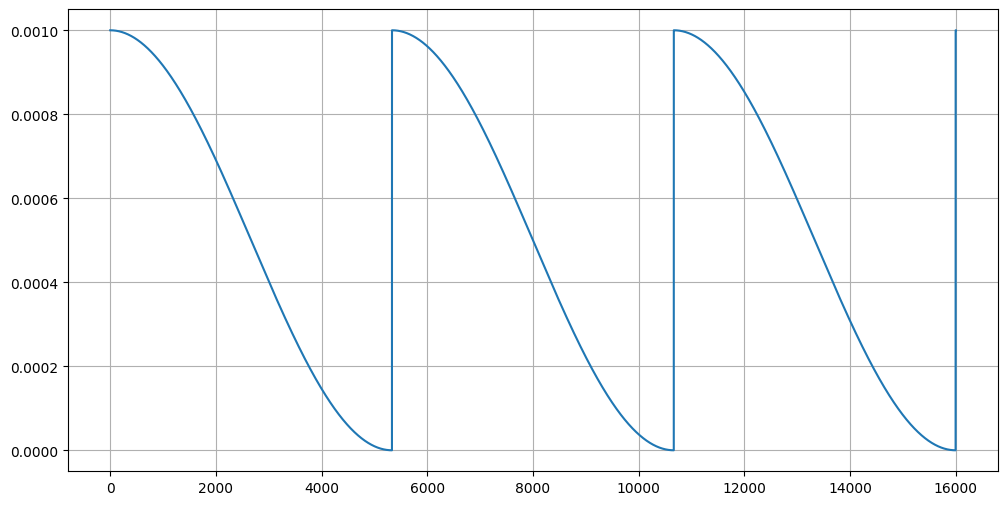

In [28]:
print('Scheduler Type is :', CFG.scheduler_type)
print('First Learning Rate is :', CFG.base_lr)
print('Last Learning Rate is :', history['LR'][-1])
print('Iteration is: ', len(history['LR']))

plt.figure(figsize=(12,6))

plt.plot(history['LR'])

plt.grid(True)
plt.show()

**Train Loss**

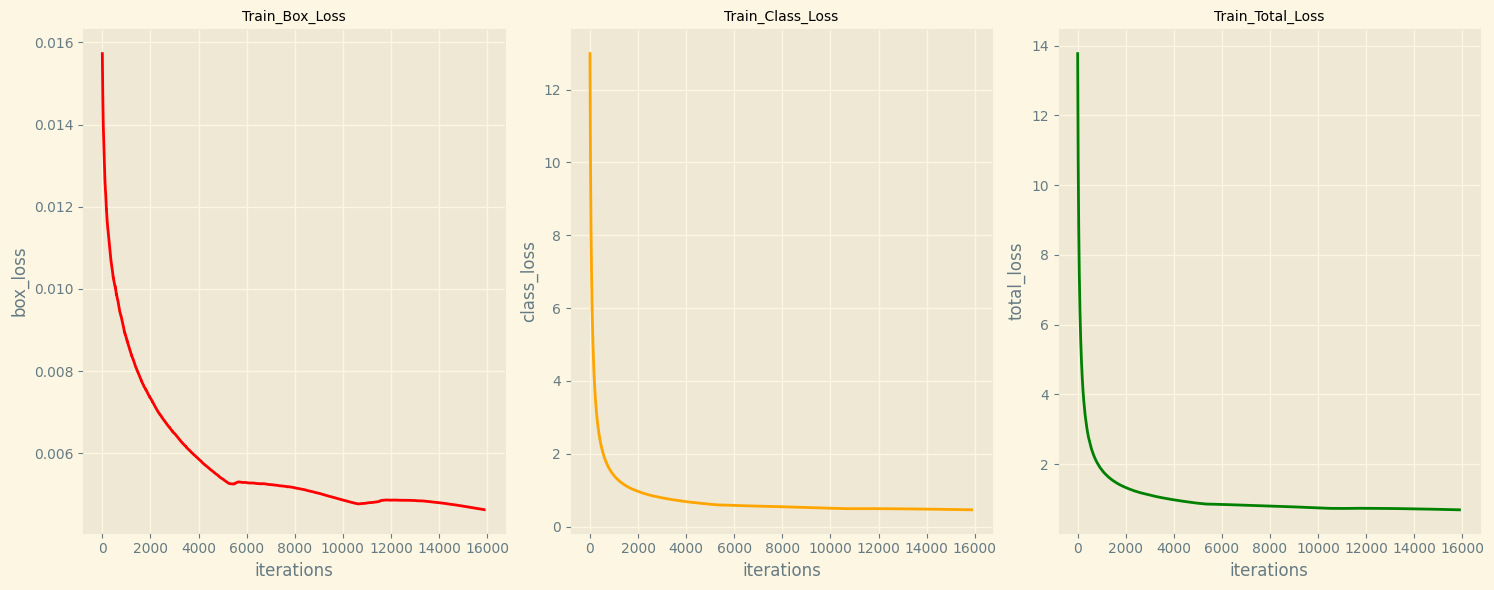

In [29]:
plt.style.use('Solarize_Light2')
plt.figure(figsize=(15,6))

plt.subplot(1,3,1)
plt.title('Train_Box_Loss', size=10)
plt.plot(history['box_loss'][len(train_loader)//5:], color='red')
plt.xlabel('iterations')
plt.ylabel('box_loss')
plt.grid(True)

plt.subplot(1,3,2)
plt.title('Train_Class_Loss', size=10)
plt.plot(history['class_loss'][len(train_loader)//5:], color='orange')
plt.xlabel('iterations')
plt.ylabel('class_loss')
plt.grid(True)

plt.subplot(1,3,3)
plt.title('Train_Total_Loss', size=10)
plt.plot(history['total_loss'][len(train_loader)//5:], color='green')
plt.xlabel('iterations')
plt.ylabel('total_loss')
plt.grid(True)

plt.tight_layout()
plt.show()

**Valid Loss**

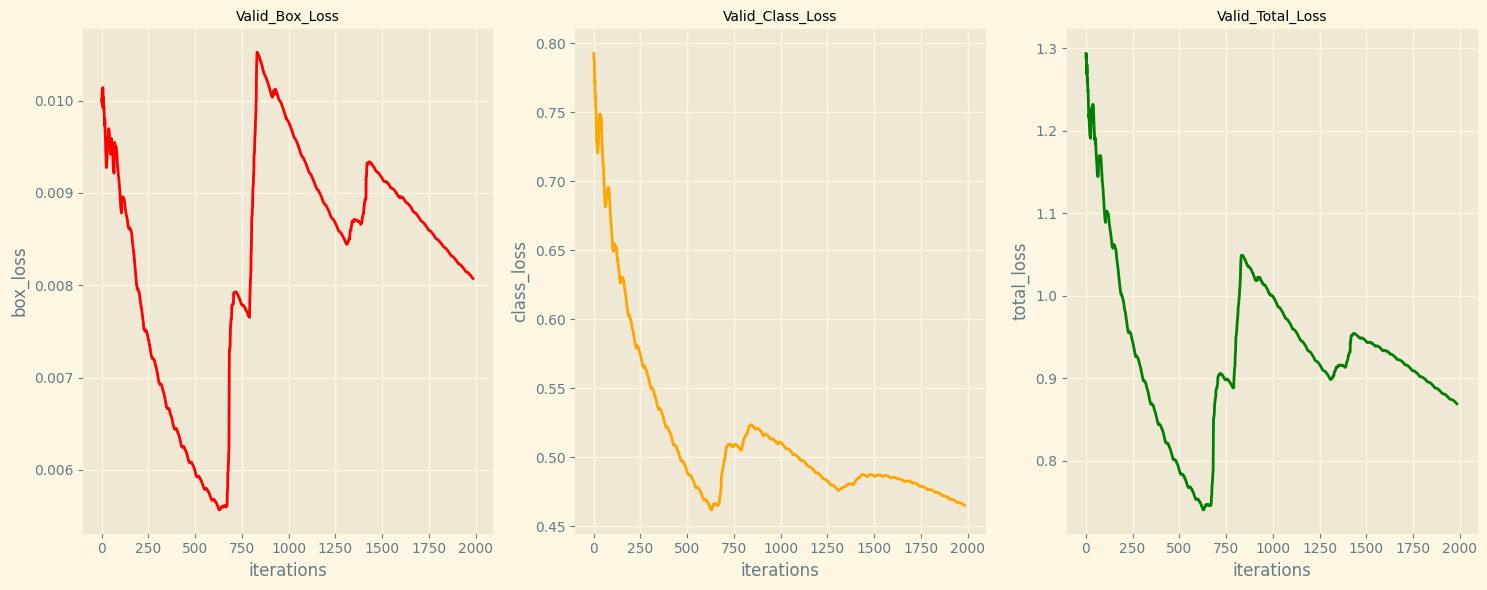

In [30]:
plt.style.use('Solarize_Light2')
plt.figure(figsize=(15,6))

plt.subplot(1,3,1)
plt.title('Valid_Box_Loss', size=10)
plt.plot(history['valid_box_loss'][len(valid_loader)//5:], color='red')
plt.xlabel('iterations')
plt.ylabel('box_loss')
plt.grid(True)

plt.subplot(1,3,2)
plt.title('Valid_Class_Loss', size=10)
plt.plot(history['valid_class_loss'][len(valid_loader)//5:], color='orange')
plt.xlabel('iterations')
plt.ylabel('class_loss')
plt.grid(True)

plt.subplot(1,3,3)
plt.title('Valid_Total_Loss', size=10)
plt.plot(history['valid_total_loss'][len(valid_loader)//5:], color='green')
plt.xlabel('iterations')
plt.ylabel('total_loss')
plt.grid(True)

plt.tight_layout()
plt.show()

In [31]:
clean_memory()
del train_loader, valid_loader, best_model, history

## 5. Validation
___

1) **Training**: `DetBenchTrain(net, config)`

2) **Inference**: `DetBenchPredict(net, config)`

In [32]:
def load_net(checkpoint_path):
    config = get_efficientdet_config(model_name=CFG.model_name)
    config.num_classes = CFG.num_classes
    config.image_size = CFG.img_size
    config.max_det_per_image = 100

    net = EfficientDet(config, pretrained_backbone=False)
    net.box_net = HeadNet(config, num_outputs=4)
    net.class_net= HeadNet(config, num_outputs=config.num_classes)

    net.load_state_dict(torch.load(checkpoint_path))

    net = DetBenchPredict(net)

    return net

In [33]:
def format_pred(boxes, scores, labels):
    pred_strings = []
    for label, score, bbox in zip(labels, scores, boxes):
        xmin, ymin, xmax, ymax = bbox.astype(np.float32)
        pred_strings.append(f"{label} {score} {xmin} {ymin} {xmax} {ymax}")
    return " ".join(pred_strings)

In [34]:
def string_decoder(predict_string):
    s = predict_string.split(' ')
    class_id = [x for x in (s[0::6])]
    score = [x for x in (s[1::6])]
    x_min = [x for x in (s[2::6])]
    y_min = [x for x in (s[3::6])]
    x_max = [x for x in (s[4::6])]
    y_max = [x for x in (s[5::6])]

    return class_id, score, x_min, y_min, x_max, y_max

**Box Format**

1) EfficientDet의 학습 bbox format: `ymin, xmin, ymax, xmax`

2) EfficientDet의 출력 bbox format: `xmin, ymin, xmin, ymin`

In [35]:
def make_predictions(images, score_threshold=0.0):
    images = torch.stack(images).to(CFG.device).float()

    net = load_net('/content/drive/MyDrive/Endoscope Detection/colonoscopy/EfficientDet/experiment/best-checkpoint.bin')
    net.to(CFG.device)
    net.eval()

    img_info = {}
    img_info['img_scale'] = torch.tensor([1] * images.shape[0], dtype=torch.float).to(CFG.device)
    img_info['img_size'] = torch.tensor([images[0].shape[-2:]] * images.shape[0], dtype=torch.float).to(CFG.device)

    predictions = []
    with torch.no_grad():

        det = net(images, img_info)
        for i in range(images.shape[0]):
            boxes = det[i].cpu().numpy()[:,:4]
            scores = det[i].cpu().numpy()[:,4]
            labels = det[i].cpu().numpy()[:,5].astype('int32')

            indexes = np.where(scores >= score_threshold)
            predictions.append({
                'boxes': boxes[indexes],
                'scores': scores[indexes],
                'labels': labels[indexes],
            })
    return predictions

In [36]:
valid_dataset = ColonoscopyDataset(
         df = valid_df,
         mode = 'test',
         image_dir = CFG.imgdir,
         transforms = get_valid_transform()
)

valid_loader = DataLoader(
        valid_dataset,
        batch_size = CFG.valid_bs,
        shuffle = False,
        drop_last = False,
        pin_memory = True,
        collate_fn = collate_fn
    )

results = []

for images, image_ids in tqdm(valid_loader, total=len(valid_loader)):
    predictions = make_predictions(images)
    for i, image in enumerate(images):
        boxes = predictions[i]['boxes']
        scores = predictions[i]['scores']
        labels = predictions[i]['labels']
        image_id = image_ids[i]

        result = {
             'image_id': image_id,
             'PredictionString': format_pred(boxes, scores, labels)
                 }
        results.append(result)

100%|██████████| 40/40 [00:47<00:00,  1.20s/it]


In [37]:
submission_det = pd.DataFrame(results, columns=['image_id','PredictionString'])
print(display(submission_det))

,image_id,PredictionString
0,2_1_00001.png,1 0.7264212369918823 167.557373046875 166.2963...
1,2_1_00009.png,1 0.6378729343414307 174.23004150390625 163.30...
2,2_1_00014.png,1 0.6164716482162476 93.86927795410156 37.6418...
3,2_1_00020.png,1 0.7877594828605652 137.26161193847656 52.597...
4,2_1_00037.png,1 0.641853392124176 80.32361602783203 90.11049...
...,...,...
314,2_2_04794.png,2 0.5327280759811401 19.842281341552734 131.70...
315,2_2_04829.png,2 0.40042319893836975 85.21978759765625 20.527...
316,2_2_04895.png,2 0.7298452258110046 99.0716552734375 189.9468...
317,2_2_05110.png,2 0.6911729574203491 125.606201171875 102.6311...


None


In [38]:
submission_list = []

for i, row in tqdm(submission_det.iterrows(), total=len(submission_det)):
    image_id = row['image_id']
    string_decoded = string_decoder(row['PredictionString'])

    for  (class_id, score, xmin, ymin, xmax, ymax) in zip(*string_decoded):
        submission_list.append(
            {
                'image_id': image_id,
                'lesion_label': int(class_id),
                'score': float(score),
                'x_min': float(xmin),
                'y_min': float(ymin),
                'x_max': float(xmax),
                'y_max': float(ymax),
                }
        )

submission_metric = pd.DataFrame(submission_list, columns=['image_id', 'lesion_label', 'score','x_min','y_min', 'x_max', 'y_max'])

100%|██████████| 319/319 [00:00<00:00, 1401.57it/s]


In [39]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [40]:
!pip install map-boxes
from map_boxes import mean_average_precision_for_boxes

Couldn't import fast version of function compute_overlap, will use slow one. Check cython intallation


In [41]:
ann = valid_df.copy()
det = submission_metric.copy()

ann['lesion_label'] -=1 ; det['lesion_label'] -= 1
ann['x_min'] *= CFG.img_size[0]/ann['width'].values[0]; ann['x_max'] *= CFG.img_size[0]/ann['width'].values[0]
ann['y_min'] *= CFG.img_size[1]/ann['height'].values[0]; ann['y_max'] *= CFG.img_size[1]/ann['height'].values[0]


ann = ann[['image_id','lesion_label','x_min','x_max','y_min','y_max']].values

det = det[['image_id','lesion_label', 'score','x_min','x_max','y_min','y_max']].values

mean_ap_50, average_precisions_50 = mean_average_precision_for_boxes(ann, det, iou_threshold=0.5)
mean_ap_75, average_precisions_75 = mean_average_precision_for_boxes(ann, det, iou_threshold=0.75)

Number of files in annotations: 319
Number of files in predictions: 319
Unique classes: 3
Detections length: 319
Annotations length: 319
0                              | 0.855067 |     151
1                              | 0.946969 |      90
2                              | 0.965014 |     159
mAP: 0.922350
Number of files in annotations: 319
Number of files in predictions: 319
Unique classes: 3
Detections length: 319
Annotations length: 319
0                              | 0.600400 |     151
1                              | 0.872409 |      90
2                              | 0.838652 |     159
mAP: 0.770487
